In [1]:
from skykatana import SkyMaskPipe

# Example usage of Skykatana

For an input catalog of HSC sources, this creates a pixelized mask or map in healsparse format, excluding areas\
due to various reasons such as bright stars, patches with low depth, etc. It also allows to combine this \
mask with arbitrary regions defined by the user\
\
Basic usage: 
* *build_footprint_mask(), build_patch_mask(), build_holes_mask()*, etc. are used to produce individual masks
* *combine_mask()* merges the maps create above to general a final mask
* *plot()* can quickly visualize a mask
* *makerans()* can generate randoms over a mask
* *apply()* can cut out sources outside of a given mask

Fixed/new features: 
* Option to add a mask due to extended (elliptical) sources
* Option to add a user defined mask (circle and quadpoly primitives)
* Stars/boxes of HSC are now in parquet format to speed up reading
* Fixed AND operation. Use intersect_boolmask() to perform intersection of arbitrary boolean masks 

Todo:
* Add healsparse as a possible format for user defined mask  
* Use eval(condstring, {col: table[col] for col in table.colnames}) to filter patches programatically by  condstring, rather than modifying the source code of filter_and_pixelate_patches()
* Add logic to control missing arguments, masks not create, wrong types, etc.
* Change makerans() output to parquet


## Define inputs

In [2]:
# Input hipscatted catalog
HIPCAT = '/home/edonoso/hscmags/hscx_hectomap_gal/'

# Bright star regions of HSC
STARS_REGIONS     = '../data/hsc_aux/stars.reg.I.nodups.parquet' 
BOX_STARS_REGIONS = '../data/hsc_aux/box.reg.I.parquet' 

# HSC patches and QA patch list ###################################### 
# Parquet patches are made by /hsc_patches/extract_patch_rects.ipynb
# See https://hsc-release.mtk.nao.ac.jp/schema/#pdr3.pdr3_wide.patch_qa
PATCH_FILE     = ['../data/hsc_aux/tracts_patches_W-hectomap.parquet','../data/hsc_aux/tracts_patches_W-AEGIS.parquet']
QA_FILE       = '../data/hsc_aux/patch_qa.csv'

# Extended sources to mask out
ELLIP_REGIONS = '../data/hsc_aux/extended_sources.parquet'

# User defined masks
USER_CIRCLE_REGIONS = '../data/hsc_aux/user_circs.txt' 
USER_POLY_REGIONS   = '../data/hsc_aux/user_polys.txt'

## Create the pipeline and run!
After SkyMaskPipe is instanciated, you can build masks (a.k.a. maps) due to various effects. Each of them is independent and can be run (or not) individually. Their results are healsparse maps stored within the class under:
* **SkyMaskPipe.foot**      :: holds the footprint map created from the input catalog
* **SkyMaskPipe.patchmap**  :: holds the map created from HSC patches matching some criteria
* **SkyMaskPipe.holemap**  :: holds the map created from bright stars and boxes around them in HSC, to mask out  
* **SkyMaskPipe.extendedmap**  :: holds the map created from a list of elliptical sources to mask out
* **SkyMaskPipe.usermap**  :: holds the footprint map created from the input catalog

Then, all/some of these masks can be combined into a final mask under **SkyMaskPipe.mask**    

In [13]:
mkp = SkyMaskPipe()
mkp.build_footprint_mask(hipcat=HIPCAT)
mkp.build_patch_mask(patchfile=PATCH_FILE, qafile=QA_FILE)
mkp.build_holes_mask(star_regs=STARS_REGIONS, box_regs=BOX_STARS_REGIONS)
mkp.build_extended_mask(ellip_regs=ELLIP_REGIONS, fmt='parquet')
mkp.combine_mask()

BUILDING FOOTPRINT MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating hipscat catalog from: /home/edonoso/hscmags/hscx_hectomap_gal/
    Order :: 13
--- Footprint map area                    : 78.07423608154203
BUILDING PATCH MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Processing ../data/hsc_aux/tracts_patches_W-hectomap.parquet
    Order :: 13
    Patches with QA                       : 4524
    Patches with QA fulfilling conditions : 2073
    Surviving patch pixels                : 1139405
--- Processing ../data/hsc_aux/tracts_patches_W-AEGIS.parquet
    Order :: 13
    Patches with QA                       : 105
    Patches with QA fulfilling conditions : 63
    Surviving patch pixels                : 34064
--- Patch map area                        : 60.112614413592695
BUILDING BRIGHT STAR HOLES MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating circles from ../data/hsc_aux/stars.reg.I.nodups.parquet
    Order :: 15
    done
--- Pixelating boxes from ../data/

--- Combined map area                     : 52.04297749532417


## Explore some plots

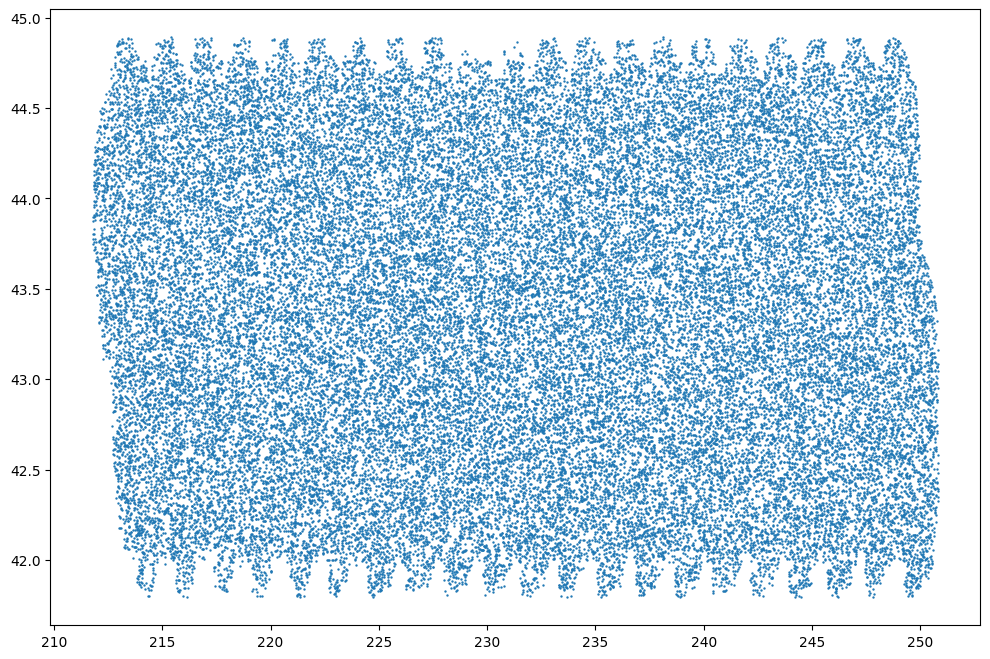

In [14]:
mkp.plot(stage='foot')

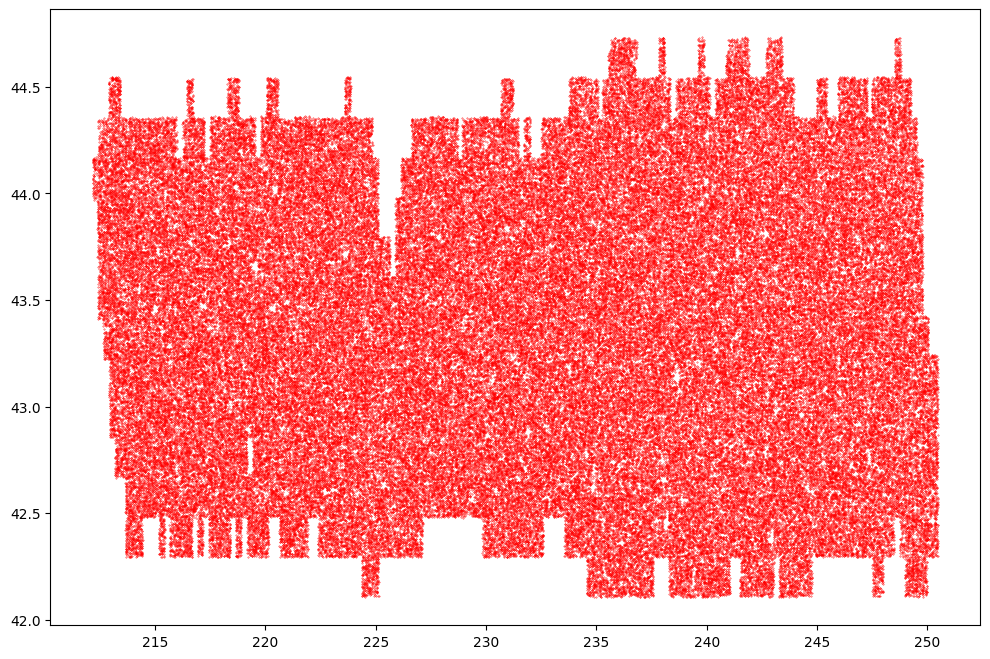

In [15]:
mkp.plot(stage='mask', nr=200_000, s=0.09, color='r')

## Generate randoms / Apply final mask to input catalog

In [12]:
rands = mkp.makerans(stage='mask', nr=500_000)
rands[0:10]

ra,dec
float64,float64
230.47068949425395,43.04652807068719
217.632036964084,42.45558663855312
249.07279153360292,42.168315633717576
217.4575957953606,44.13952443495938
224.2335040468243,44.14908561306345
244.00533748139307,42.88287927193792
223.88292046612918,44.25042911564848
248.42088138283543,44.1825803791019
248.4330404474275,42.545668735445865


In [ ]:
# Use apply() to return a catalog filtered by the mask
import lsdb
srcs = lsdb.read_hipscat(HIPCAT, columns=['ra_mag','dec_mag']).compute()
srcs_masked = mkp.apply(stage='mask', cat=srcs, columns=['ra_mag','dec_mag'])

## Now add a user-defined mask

In [16]:
mkp.build_user_mask(circ_uregs=USER_CIRCLE_REGIONS, poly_uregs=USER_POLY_REGIONS)
mkp.combine_mask(apply_usermap=True)        # By default apply_usermap=False

BUILDING USER DEFINED MAP >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Pixelating circles from ../data/hsc_aux/user_circs.txt
    Order :: 15
    done
--- Pixelating polygons from ../data/hsc_aux/user_polys.txt
    Order :: 15
--- User map area                         : 16.550064891996875
COMBINING MAPS >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
--- Combined map area                     : 8.747096701615638


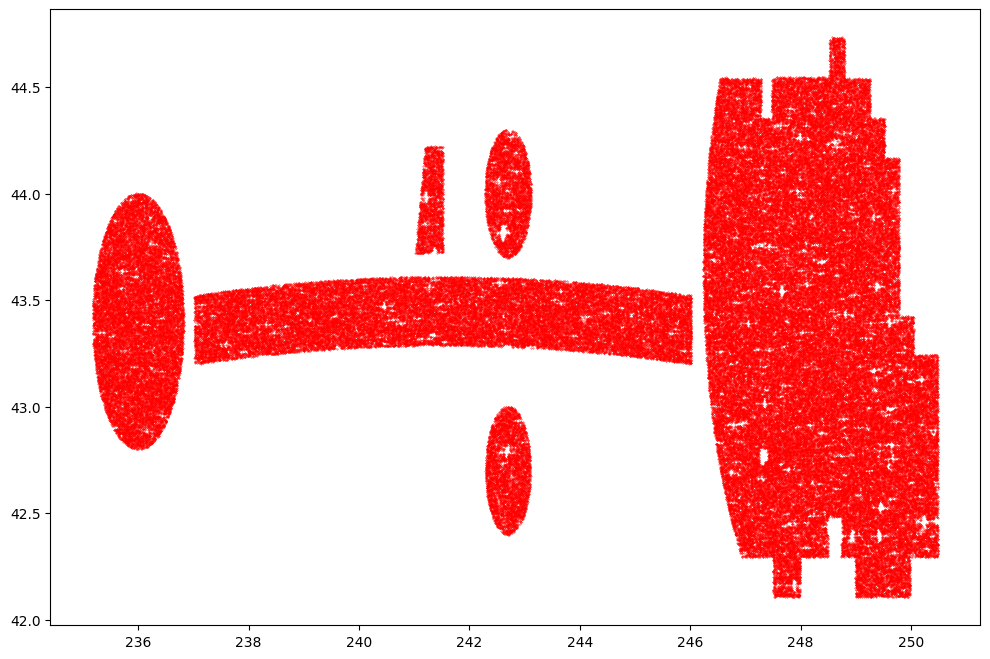

In [17]:
mkp.plot(stage='mask', nr=200_000, s=0.09, color='r')